In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

### 讀取原始資料

In [2]:
# 讀資料
item = 'A'  # 選擇要載入的'品項'
Location = pd.ExcelFile('./data/歷史出入庫資料-益張.xlsx')
df = pd.read_excel(Location, item)
df

,品項,異動日期,入/出庫,異動數量
0,A,2020/03/19,入庫,647
1,A,2020/03/24,入庫,193
2,A,2020/03/24,入庫,330
3,A,2020/03/26,出庫,330
4,A,2020/03/27,出庫,840
...,...,...,...,...
350,A,2022/02/15,出庫,546
351,A,2022/02/17,入庫,865
352,A,2022/02/17,入庫,600
353,A,2022/02/17,入庫,225


### ERP數據前處理

In [3]:
# 將日期轉成年分
df['異動日期'] = pd.to_datetime(df['異動日期'])  # 先將日期轉成Datetime格式
df['Year'] = df['異動日期'].dt.year  # 加入年份

# 將日期轉換成週數
df['week'] = df['異動日期'].dt.isocalendar().week #加入週數
#df['week'] = pd.DatetimeIndex(df['異動日期']).week  # 另一種寫法
df

,品項,異動日期,入/出庫,異動數量,Year,week
0,A,2020-03-19,入庫,647,2020,12
1,A,2020-03-24,入庫,193,2020,13
2,A,2020-03-24,入庫,330,2020,13
3,A,2020-03-26,出庫,330,2020,13
4,A,2020-03-27,出庫,840,2020,13
...,...,...,...,...,...,...
350,A,2022-02-15,出庫,546,2022,7
351,A,2022-02-17,入庫,865,2022,7
352,A,2022-02-17,入庫,600,2022,7
353,A,2022-02-17,入庫,225,2022,7


In [4]:
# 將入/出庫拆開
put_in = df
check_out = df
for i in range(df.shape[0]):
    if df['入/出庫'].values[i] == '出庫':
        put_in = put_in.drop(index=[i])  # 刪除出庫，只剩入庫
    elif df['入/出庫'].values[i] == '入庫':
        check_out = check_out.drop(index=[i])
    else:
        print("Error")

print("入庫筆數:", len(put_in))
print("出庫筆數:", len(check_out))
put_in

入庫筆數: 213
出庫筆數: 142


,品項,異動日期,入/出庫,異動數量,Year,week
0,A,2020-03-19,入庫,647,2020,12
1,A,2020-03-24,入庫,193,2020,13
2,A,2020-03-24,入庫,330,2020,13
5,A,2020-04-01,入庫,195,2020,14
6,A,2020-04-03,入庫,198,2020,14
...,...,...,...,...,...,...
347,A,2022-02-11,入庫,750,2022,6
348,A,2022-02-11,入庫,135,2022,6
351,A,2022-02-17,入庫,865,2022,7
352,A,2022-02-17,入庫,600,2022,7


In [5]:
# 相同"異動日期"做加總 + 移動到index
sum_put_in = put_in.groupby(['異動日期'], as_index=False)['異動數量'].sum()  # sum quantitys
sum_put_in['異動日期'] = pd.to_datetime(sum_put_in['異動日期'])  # convert to datetime
sum_put_in = sum_put_in.set_index("異動日期")  # to index
sum_put_in

,異動數量
異動日期,
2020-03-19,647
2020-03-24,523
2020-04-01,195
2020-04-03,198
2020-04-06,322
...,...
2022-01-13,2457
2022-02-08,593
2022-02-10,1270


In [6]:
# 補齊"異動日期"之日數
sum_put_in = sum_put_in.resample("D").mean().fillna(0)  # 空值填0
sum_put_in = sum_put_in.reset_index()
sum_put_in['Year'] = sum_put_in['異動日期'].dt.isocalendar().year  #需加isocalendar()才不會算錯 
sum_put_in['week'] = sum_put_in['異動日期'].dt.isocalendar().week
sum_put_in

,異動日期,異動數量,Year,week
0,2020-03-19,647.0,2020,12
1,2020-03-20,0.0,2020,12
2,2020-03-21,0.0,2020,12
3,2020-03-22,0.0,2020,12
4,2020-03-23,0.0,2020,13
...,...,...,...,...
696,2022-02-13,0.0,2022,6
697,2022-02-14,0.0,2022,7
698,2022-02-15,0.0,2022,7
699,2022-02-16,0.0,2022,7


In [7]:
# columns -> index
sum_put_in = sum_put_in.groupby(['Year','week']).aggregate(sum)
sum_put_in

異動數量
Year week        
2020 12     647.0
     13     523.0
     14     393.0
     15     812.0
     16    1000.0
...           ...
2022 3        0.0
     4        0.0
     5        0.0
     6     2748.0
     7     1690.0

[101 rows x 1 columns]

In [8]:
# check_out做一樣的事
sum_check_out = check_out.groupby(['異動日期'], as_index=False)['異動數量'].sum()  # sum quantitys
sum_check_out['異動日期'] = pd.to_datetime(sum_check_out['異動日期'])  # convert to datetime
sum_check_out = sum_check_out.set_index("異動日期")  # to index
sum_check_out = sum_check_out.resample("D").mean().fillna(0)  # 空值填0
sum_check_out = sum_check_out.reset_index()
sum_check_out['Year'] = sum_check_out['異動日期'].dt.isocalendar().year
sum_check_out['week'] = sum_check_out['異動日期'].dt.isocalendar().week
sum_check_out = sum_check_out.groupby(['Year','week']).aggregate(sum)
sum_check_out

異動數量
Year week        
2020 13    1170.0
     14       0.0
     15    1205.0
     16     955.0
     17     610.0
...           ...
2022 4     1000.0
     5        0.0
     6     1441.0
     7     1146.0
     8      985.0

[101 rows x 1 columns]

### 出入庫-統一日期範圍

In [9]:
# 合併DataFrame (取聯集=outer, 交集=inner)
sum_merge = pd.merge(sum_put_in, sum_check_out, on=['Year','week'], how='outer', suffixes=('_put_in', '_check_out'))
sum_merge = sum_merge.fillna(0)
sum_merge.head(10)

異動數量_put_in  異動數量_check_out
Year   week                             
2020.0 12.0        647.0             0.0
       13.0        523.0          1170.0
       14.0        393.0             0.0
       15.0        812.0          1205.0
       16.0       1000.0           955.0
       17.0        565.0           610.0
       18.0       1020.0           278.0
       19.0       1415.0           610.0
       20.0        630.0           963.0
       21.0       1370.0          1901.0

In [10]:
# 抓出其中入庫量
sum_put_in = sum_merge
sum_put_in = sum_put_in.drop(columns='異動數量_check_out')
sum_put_in = sum_put_in.rename(columns={'異動數量_put_in':'異動數量'}) 
sum_put_in

異動數量
Year   week        
2020.0 12.0   647.0
       13.0   523.0
       14.0   393.0
       15.0   812.0
       16.0  1000.0
...             ...
2022.0 4.0      0.0
       5.0      0.0
       6.0   2748.0
       7.0   1690.0
       8.0      0.0

[102 rows x 1 columns]

In [11]:
# 抓出其中出庫量
sum_check_out = sum_merge
sum_check_out = sum_check_out.drop(columns='異動數量_put_in')
sum_check_out = sum_check_out.rename(columns={'異動數量_check_out':'異動數量'}) 
sum_check_out

異動數量
Year   week        
2020.0 12.0     0.0
       13.0  1170.0
       14.0     0.0
       15.0  1205.0
       16.0   955.0
...             ...
2022.0 4.0   1000.0
       5.0      0.0
       6.0   1441.0
       7.0   1146.0
       8.0    985.0

[102 rows x 1 columns]

### 庫存量

In [12]:
# 庫存相差量 = 入庫量 - 出庫量
inventory = sum_put_in.sub(sum_check_out, fill_value=0)  # fill_value: 自動補齊缺失計算
inventory['相差量'] = inventory['異動數量']
inventory

異動數量     相差量
Year   week                
2020.0 12.0   647.0   647.0
       13.0  -647.0  -647.0
       14.0   393.0   393.0
       15.0  -393.0  -393.0
       16.0    45.0    45.0
...             ...     ...
2022.0 4.0  -1000.0 -1000.0
       5.0      0.0     0.0
       6.0   1307.0  1307.0
       7.0    544.0   544.0
       8.0   -985.0  -985.0

[102 rows x 2 columns]

In [13]:
# 庫存累計量 = 做累加計算
inventory['異動數量'] = inventory['相差量'].cumsum()
inventory = inventory.rename(columns={'異動數量':'庫存量'})  # 修改columns名稱
inventory

庫存量     相差量
Year   week                
2020.0 12.0   647.0   647.0
       13.0     0.0  -647.0
       14.0   393.0   393.0
       15.0     0.0  -393.0
       16.0    45.0    45.0
...             ...     ...
2022.0 4.0   1376.0 -1000.0
       5.0   1376.0     0.0
       6.0   2683.0  1307.0
       7.0   3227.0   544.0
       8.0   2242.0  -985.0

[102 rows x 2 columns]

### 輸出Excel結果

In [14]:
sum_put_in.to_excel('./data/sum_put_in.xlsx', sheet_name=item, index=True)
sum_check_out.to_excel('./data/sum_check_out.xlsx', sheet_name=item, index=True)
inventory.to_excel('./data/inventory.xlsx', sheet_name=item, index=True)

### 可視化結果

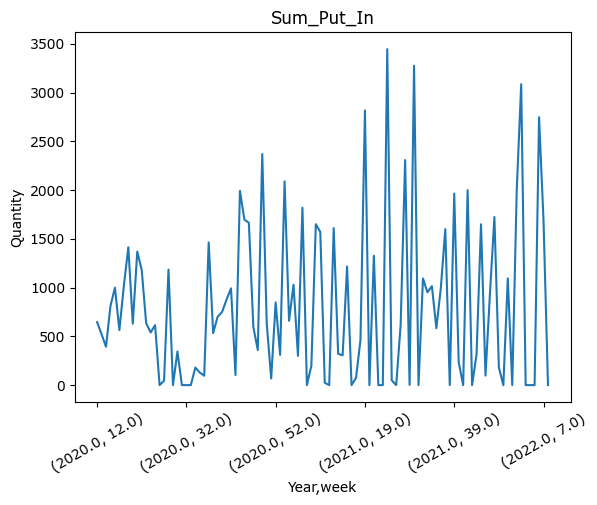

In [15]:
sum_put_in.plot(legend=None, title='Sum_Put_In')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

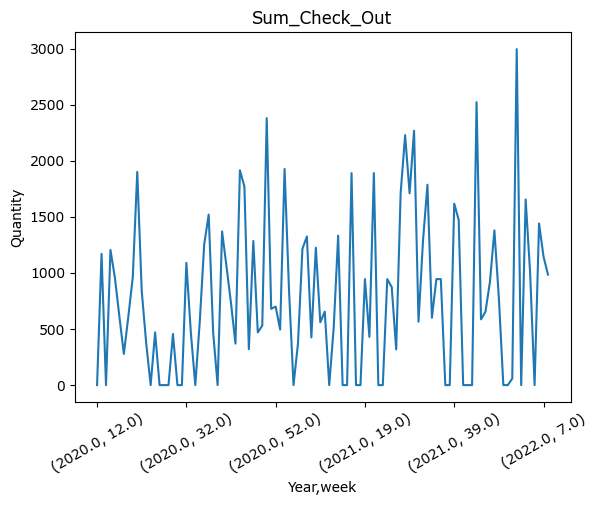

In [16]:
sum_check_out.plot(legend=None, title='Sum_Check_Out')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

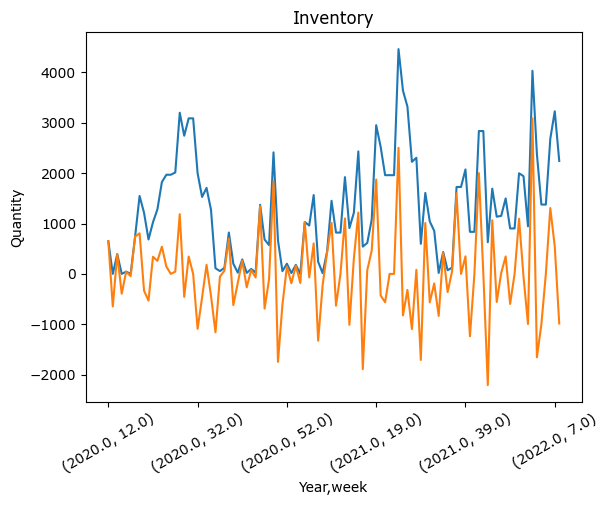

In [17]:
# 藍色: 每週庫存量
# 橘色: 相差量
inventory.plot(legend=None, title='Inventory')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");